In [100]:
# Import everything we will need
import spectrapepper
from matplotlib.pyplot import subplots, show
from spectrapepper import alsbaseline
from pathlib import Path
import numpy as np
from astropy.io import fits
from matplotlib.pyplot import figure, show, close
import matplotlib as mpl
from astropy.visualization import ImageNormalize, SquaredStretch
import scipy.signal as ss
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

In [101]:
# Define where the directory is located
datadir2 = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Live"
datadir = "C:/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope"
procdir = "/Users/stefa/OneDrive/Documenten/Blaauw images/Spectroscope/Process/i"

# Use pathlib.Path to create a pathobject
pathobject = Path(datadir)
pathobject2 = Path(datadir2)

myfitsfiles = []
myfitsfiles2 = []

# Loop over all files in the directory and grab the fits files
for f in pathobject.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles.append(f)

for f in pathobject2.iterdir():
    if f.suffix.lower() in ['.fits', '.fit', '.fts']:
        myfitsfiles2.append(f)

# Print first 10 fitsfiles to check if we got everything correct        
for i in range(10):
    print(myfitsfiles[i])

C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000001.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000002.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000003.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000004.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000005.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000006.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000007.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000008.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000009.BIAS.FIT
C:\Users\stefa\OneDrive\Documenten\Blaauw images\Spectroscope\240410_Xs.00000010.BIAS.FIT


In [102]:
# Create the image class

class image:
    def __init__(self, filepath, fits_imagetyp='', fits_exptime=0, fits_filter='', fits_date_obs=0, fits_naxis1=0, fits_naxis2=0, pixelsize=18):
        self.filepath = filepath
        self.filename = filepath.name
        self.imagetyp = fits_imagetyp
        self.exptime = fits_exptime
        self.filter = fits_filter
        self.date_obs = fits_date_obs
        self.naxis1 = fits_naxis1
        self.naxis2 = fits_naxis2
        self.pixelsize = pixelsize

myimages = []
myimages2 = []

# Loop over all of the filepaths in myfitsfiles, open each image, give it the image class and append it to the list of images
for filepath in myfitsfiles:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages.append(newimage)
    hdulist.close()

for filepath in myfitsfiles2:
    hdulist = fits.open(filepath)
    hdr = hdulist[0].header
    # Assumes same pixelsize in x and y
    newimage = image(filepath, hdr.get('IMAGETYP'), hdr.get('EXPTIME'), hdr.get('FILTER'), hdr.get('DATE-OBS'), hdr.get('NAXIS1'), hdr.get('NAXIS2'), hdr.get('XPIXSZ'))
    myimages2.append(newimage)
    hdulist.close()

# Comment for self: Dark Frame, Bias Frame, Flat Field, Light Frame

In [103]:
# Create the masterbias
# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Bias_list = []
count = 0
for im in myimages2:
    if 'bias frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Bias_list.append(dat)
        hdulist.close

# Then we median combine the images        
Bias_stack = np.stack(Bias_list)
masterbias = np.median(Bias_stack, axis=0)

del Bias_list, Bias_stack

In [104]:
# Create the masterdark
# Loop over all the images in our list and check if they are Dark frames, if they are append them to the list
# We didn't have time to shoot our own darks, so we used older ones

Darks_list = []
count = 0
for im in myimages:
    if 'dark frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Darks_list.append((dat - masterbias)/im.exptime)
        hdulist.close

# Then we median combine the darks
Darks_stack = np.stack(Darks_list)
masterdark = np.median(Darks_stack, axis=0)

del Darks_list, Darks_stack

In [105]:
# Let's do the masterflat next

# Loop over all the images in our list and check if they are Bias frames, if they are we append them to the Bias_list
Flats_list = []
count = 0
for im in myimages2:
    if 'flat field' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        dat = hdulist[0].data
        Flats_list.append(dat)
        hdulist.close
# 
# # Lets inspect the Flats
# c = 0
# for obj in Flats_list:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     norm = ImageNormalize(stretch=SquaredStretch())
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray', norm=norm)
#     frame.set_title(f"{c}, min = {np.min(obj)}, max = {np.max(obj)}")
#     show(fig)
#     close(fig)
#     c += 1

# We see that the first 5 show a proper flat
Flats_list_sorted = Flats_list[0:4]

# Then we calibrate the flats with masterbias and median combine the images (We don't need to concern with the darks as the dark current can't really build up during flats)
Flats_stack = np.stack(Flats_list_sorted - masterbias)
masterflat = np.median(Flats_stack, axis=0)

del Flats_list,Flats_list_sorted, Flats_stack


# Flats_stack_normalized = Flats_stack / Flats_median
# masterflat_to_be_normalized = np.median(Flats_stack_normalized, axis=0)
# masterflat = masterflat_to_be_normalized / np.median(masterflat_to_be_normalized)

In [106]:
# Now that we have our master calibration files we can work on our lights, first we calibrate using darks and bias
# Flat calibration will be done later in the processing, because the dark areas between the fibres mess up the median
lights = []
for im in myimages2:
    if 'light frame' in im.imagetyp.lower():
        hdulist = fits.open(im.filepath)
        data = hdulist[0].data.astype(float)
        data -= masterdark*im.exptime + masterbias
        lights.append(data)
        hdulist.close

# Let's inspect the lights
# c = 0
# for obj in lights:
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.imshow(obj, interpolation='none', origin='lower', cmap='gray')
#     frame.set_title(f"light {c} with min: {obj.min()}, max: {obj.max()}")
#     show(fig)
#     close(fig)
#     c += 1

In [107]:
def median_combine(lights_sorted):
    '''
    :param: lights_sorted: list of light frames
    :return: median of light frames 
    '''
    return np.median(np.stack(lights_sorted), axis=0)


# Based on the logsheet and printing all images we determine the following sorting of the targets
lights_sorted_galaxy = lights[32:34]+lights[36:42]
lights_sorted_vega = lights[43:48]
lights_sorted_moon = lights[-5:-1]
lights_calibration = lights[21:25]
lights_sorted_arcturus = lights[29:31]
lights_sorted_regulus = lights[26:27]

del lights

master_galaxy = median_combine(lights_sorted_galaxy)
master_vega = median_combine(lights_sorted_vega)
master_moon = median_combine(lights_sorted_moon)
master_calibration = median_combine(lights_calibration)
master_arcturus = median_combine(lights_sorted_arcturus)
master_regulus = median_combine(lights_sorted_regulus)

In [108]:
# We need to know where the spectral lines are. This is easiest done by using the flat frames first slice in a vertical line
vert_slice = masterflat[:,1000]

# Based on the plot we want to exclude values with less then 10000 counts
fibre_locations = np.where(vert_slice>1000)[0]

# Now we would like to group all of the values in a single fibre into a single median value to reduce noise, although we do clearly see that the values on the outside are significantly less then the ones in the center.
fibre_locations_dict = {}
i = 1
n = "fibre_0"
c = 0

for obj in fibre_locations:
    try:
        if obj+1 == fibre_locations[i]:
            try:
                fibre_locations_dict[n].append(obj)
            except:
                fibre_locations_dict[n] = []
                fibre_locations_dict[n].append(obj)
        else:
            fibre_locations_dict[n].append(obj)
            c+=1
            n = f'fibre_{c}'
        i+=1

    except:
        fibre_locations_dict[n].append(obj)
        
# print(fibre_locations_dict)
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# frame.plot(vert_slice)
# # frame.axis([600, 700, 8, 10])
# frame.set_title('Veritcal slice at x = 1000')
# frame.set_xlabel('Pixel from top to bottom')
# frame.set_ylabel('Intensity [counts]')
# frame.grid(alpha = 0.5)
# fig.savefig('Flatfield.png', dpi=300)
# show(fig) 
# close(fig)

In [109]:
# Now that we have the locations of the fibres we make an intensity plot of the median of all the collumns that a fibre consists of.
def find_maximum_slice(horizontal_slice_dict):
    '''
    :purpose: Finds the location of the slice which contains the maximum value
    :input: Dictionary medians of horizontal slices
    :return: The location of the slice which contains the maximum value
    '''
    Total_max = np.max(horizontal_slice_dict['fibre_0'])
    for i in horizontal_slice_dict:
        Max_of_row = np.max(horizontal_slice_dict[i])
        if Max_of_row>Total_max:
            Total_max = Max_of_row
            location = i
    return location

def average_fibre(fibre_locations_dict,master,flat_slice_dict={}):
    '''
    :purpose: Calculates the weighted average of each fibre
    :param: fibre_locations_dict, master
    :return: Dictionary of numbered fibres
    '''
    if len(flat_slice_dict)==0:
        flat_slice_dict = {}
        flat_slice_average_dict = {}
        for i in fibre_locations_dict:
            flat_slice = master[fibre_locations_dict[i],:]
            flat_slice_dict[i] = flat_slice
            flat_slice_average_dict[i] = np.average(flat_slice, axis=0, weights=flat_slice)
        return flat_slice_dict,flat_slice_average_dict
    else:
        horizontal_slice_dict_average = {}
        for i in fibre_locations_dict:
            horizontal_slice = master[fibre_locations_dict[i],:]
            horizontal_slice_dict_average[i] = np.average(horizontal_slice, axis=0, weights = flat_slice_dict[i])
        return horizontal_slice_dict_average

# Calculate the weighted average of each of the fibres     
flat_slice_dict, flat_slice_average_dict = average_fibre(fibre_locations_dict,masterflat)
horizontal_slice_galaxy_dict = average_fibre(fibre_locations_dict,master_galaxy,flat_slice_dict)
horizontal_slice_vega_dict = average_fibre(fibre_locations_dict,master_vega,flat_slice_dict)
horizontal_slice_moon_dict = average_fibre(fibre_locations_dict,master_moon,flat_slice_dict)
horizontal_slice_calibration_dict = average_fibre(fibre_locations_dict,master_calibration,flat_slice_dict)
horizontal_slice_arcturus_dict = average_fibre(fibre_locations_dict,master_arcturus,flat_slice_dict)
horizontal_slice_regulus_dict = average_fibre(fibre_locations_dict,master_regulus,flat_slice_dict)

# We want to save the horizontal_slice_dict and use it in further stuff
location_of_maximum_galaxy_dict = find_maximum_slice(horizontal_slice_galaxy_dict)
location_of_maximum_vega = find_maximum_slice(horizontal_slice_vega_dict)
location_of_maximum_moon = find_maximum_slice(horizontal_slice_moon_dict)
location_of_maximum_calibration = find_maximum_slice(horizontal_slice_calibration_dict)
location_of_maximum_arcturus = find_maximum_slice(horizontal_slice_arcturus_dict)
location_of_maximum_regulus = find_maximum_slice(horizontal_slice_regulus_dict)

In [110]:
# Shift calculation based on the biggest spike in the calibration data!
def calculate_shifts(calibration_dict):
    ''''
    :purpose: Calculates the relative shift between the fibres using the calibration data
    :param calibration_dict: Dictionary of numbered fibres of calibration data
    :return shifts: Dictionary of shifts as to allign all fibres 
    '''
    Maximums = {}
    Maximums_list = []
    shifts = {}

    for i in calibration_dict.keys():
        Maximum = np.where(calibration_dict[i]==np.max(calibration_dict[i]))[0][0]
        Maximums[i] = Maximum
        Maximums_list.append(Maximum)
    centre = np.median(Maximums_list)

    for i in calibration_dict.keys():
        shifts[i] = centre - Maximums[i]
    return(shifts)

shifts = calculate_shifts(horizontal_slice_calibration_dict)

In [111]:
def align_spectra(average_dict, shifts):
    '''
    :purpose: Aligns and crops all the fibres such that there is no longer a relative horizontal shift between the fibres
    :param average_dict: Dictionary of light frames
    :param shifts: Dictionary of relative shifts
    :return cropped: Dictionary of aligned fibres
    '''
    # First align the fibres
    aligned_average_dict = {}
    for i in average_dict.keys():
        if shifts[i] > 0:
            shift = int(shifts[i])
            aligned_average_dict[i] = average_dict[i][shift::]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],0,np.zeros(shift))
        if shifts[i] < 0:
            shift = int(abs(shifts[i]))
            aligned_average_dict[i] = average_dict[i][:-shift:]
            aligned_average_dict[i] = np.insert(aligned_average_dict[i],-1,np.zeros(shift))
        else:
            aligned_average_dict[i] = average_dict[i]

    # After alligning we can crop
    maximum_shift = 0
    minimum_shift = 0
    cropped = {}
    for i in shifts:
        if shifts[i] > maximum_shift:
            maximum_shift = shifts[i]
        elif shifts[i] < minimum_shift:
            minimum_shift = shifts[i]

    minimum_shift = int(abs(minimum_shift))
    maximum_shift = int(abs(maximum_shift))

    for i in aligned_average_dict.keys():
        cropped[i] = aligned_average_dict[i][maximum_shift:-minimum_shift:]

    return cropped

def background_subtraction(aligned_average_dict):
    '''
    :purpose: subtract the background to see fainter emmision and absorption lines
    :param aligned_average_dict: Dictionary of light frames
    :return background_subtracted: Dictionary of background subtracted fibres
    '''
    aligned_average_list = []
    for i in aligned_average_dict.keys():
        aligned_average_list.append(aligned_average_dict[i])
    aligned_stack = np.stack(aligned_average_list)
    background = np.median(aligned_stack, axis=0)

    background_subtracted = {}
    for i in aligned_average_dict.keys():
        background_subtracted[i] = aligned_average_dict[i] / background
    return background_subtracted

# fix the relative shift between the fibres
cropped_flat = align_spectra(flat_slice_average_dict, shifts)
cropped_galaxy = align_spectra(horizontal_slice_galaxy_dict, shifts)
cropped_vega = align_spectra(horizontal_slice_vega_dict, shifts)
cropped_moon = align_spectra(horizontal_slice_moon_dict, shifts)
cropped_calibration = align_spectra(horizontal_slice_calibration_dict, shifts)
cropped_arcturus = align_spectra(horizontal_slice_arcturus_dict, shifts)
cropped_regulus = align_spectra(horizontal_slice_regulus_dict, shifts)

# Background subtract the galaxy data
galaxy_background_subtracted = background_subtraction(cropped_galaxy)

# for fibre in galaxy_background_subtracted.keys():
#     fig = figure()
#     frame = fig.add_subplot(1,1,1)
#     frame.plot(cropped_flat[fibre])
#     # frame.plot(wavelength_calibrated, aligned_average_dict[fibre]/aligned_average_dict[fibre].max())
#     frame.set_title(f"Background subtracted {fibre}")
#     frame.grid() 
#     show(fig)
#     close(fig)

[ 502  567 1041 1058 1309 1597 1613 1836 1843 1908 1910 1944]


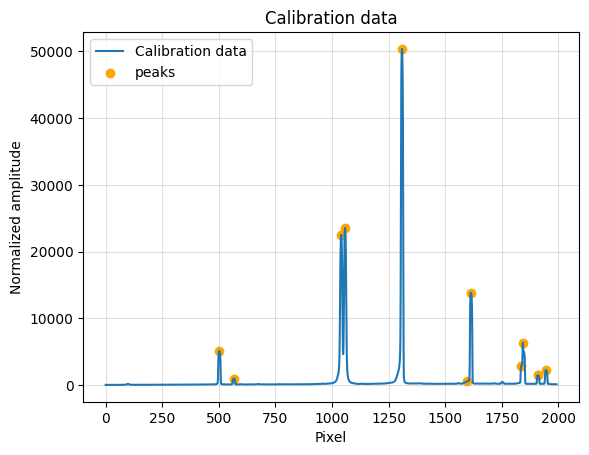

In [112]:
# get the actual peaks
peaks, _ = find_peaks(cropped_calibration[location_of_maximum_calibration], height=500)

print(peaks)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(cropped_calibration[location_of_maximum_calibration], label = 'Calibration data')
frame.scatter(peaks, cropped_calibration[location_of_maximum_calibration][peaks],color='orange', label = 'peaks', marker = 'o')
frame.set_title(f"Calibration data")
frame.set_ylabel('Normalized amplitude')
frame.set_xlabel('Pixel')
frame.grid(alpha = 0.4)
frame.legend(loc = 'upper left')
fig.savefig('Calibration data')
show(fig)
close(fig)


# # Create visual for presentation
# fibres = ['fibre_5', 'fibre_15', 'fibre_25', 'fibre_35', 'fibre_45', 'fibre_55']
# 
# fig = figure()
# frame = fig.add_subplot(1,1,1)
# for fibre in fibres:
#     frame.plot(calibration_horizontal_dict[fibre]/np.max(calibration_horizontal_dict[fibre]), label = fibre)
# frame.axis([450, 550, 0, 0.15])
# frame.set_title(f"Calibration data shift")
# frame.set_ylabel('Normalized amplitude')
# frame.set_xlabel('Pixel')
# frame.grid(alpha = 0.4)
# frame.legend()
# fig.savefig('Calibration data shift')
# show(fig)
# close(fig)

 
-1.217 x + 7053


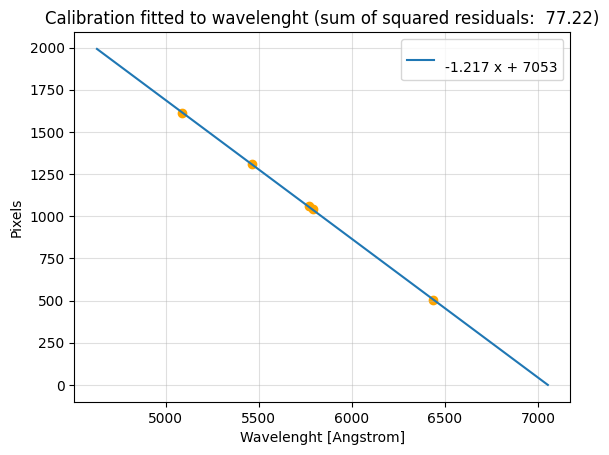

In [113]:
pixels_xaxis = cropped_calibration[location_of_maximum_calibration].shape[0]

# We don't want to use all of the peaks because some cannot be identified
Our_peak_location = peaks[np.array([0,2,3,4,6])]
Calibration_peak_locations = np.array([6438, 5791, 5770, 5461, 5086])

Lenght_our_x_axis = np.arange(0,pixels_xaxis, 1)

def wavelengthfit(a1,c1, degree):
    ''''
    :purpose: Function to calculate the wavelength calibration polynomial
    :param: a1 and c1 are arrays where the first is the pixel values found and c1 are the wavelength values
    :return: wavelength calibration polynomial
    '''
    y = np.polyfit(a1,c1,degree, full=True)
    return(y)

Function = (wavelengthfit(Our_peak_location,Calibration_peak_locations, 1))
y = np.poly1d(Function[0])

print(y)

wavelength_calibrated = np.polyval(y, Lenght_our_x_axis)
# cropped_wavelength = wavelength_calibrated[maximum_shift:-minimum_shift:]

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Lenght_our_x_axis, label = y)
frame.scatter(Calibration_peak_locations, Our_peak_location, color='orange')
# frame.plot(Y, range(Y.size))
frame.set_title(f"Calibration fitted to wavelenght (sum of squared residuals: {Function[1][0]: .4})")
frame.grid(alpha = 0.4)
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Pixels')
fig.savefig('Calibration fitted to wavelenght.png', dpi=300)
show(fig)
close(fig)

In [114]:
Vega_flat_calibrated = cropped_vega[location_of_maximum_vega]/(cropped_flat[location_of_maximum_vega]/np.median(cropped_flat[location_of_maximum_vega]))
Regulus_flat_calibrated = cropped_regulus[location_of_maximum_regulus]/(cropped_flat[location_of_maximum_regulus]/np.median(cropped_flat[location_of_maximum_regulus]))
Arcturus_flat_calibrated = cropped_arcturus[location_of_maximum_arcturus]/(cropped_flat[location_of_maximum_arcturus]/np.median(cropped_flat[location_of_maximum_arcturus]))
Moon_flat_calibrated = cropped_moon[location_of_maximum_moon]/(cropped_flat[location_of_maximum_moon]/np.median(cropped_flat[location_of_maximum_moon]))

In [115]:
vega_calibration = np.loadtxt('miles_spec_txt_s0592.txt')

wavelength = []
values = []

size = int(vega_calibration.size/2)

for i in range(size):
    wavelength.append(vega_calibration[i][0])
    values.append(vega_calibration[i][1])

# convert both to np arrays
vega_calibration_wavelength = np.array(wavelength)
vega_calibration_values = np.array(values)

# First we get the max and min values of our actual data
minimum_wavelength = wavelength_calibrated[-1]
maximum_wavelength = wavelength_calibrated[0]

# We crop the calibration data to our range
mask1 = vega_calibration_wavelength > minimum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask1]
vega_calibration_values = vega_calibration_values[mask1]

mask2 = vega_calibration_wavelength < maximum_wavelength
vega_calibration_wavelength = vega_calibration_wavelength[mask2]
vega_calibration_values = vega_calibration_values[mask2]

# Then we interpolate the calibration data so it matches ours
# la = len(aligned_average_dict[location_of_maximum])

interpolated_vega_calibration_values = np.interp(wavelength_calibrated, vega_calibration_wavelength, vega_calibration_values)

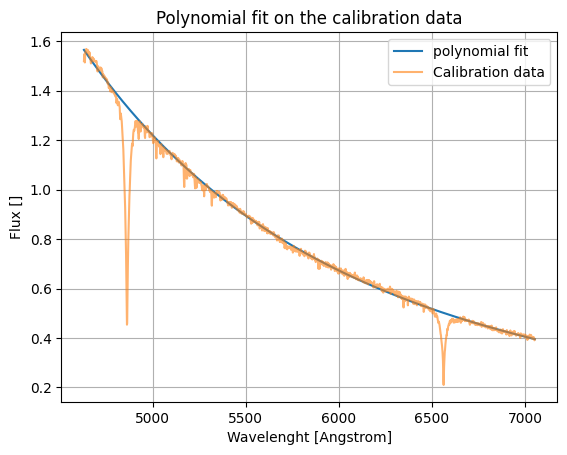

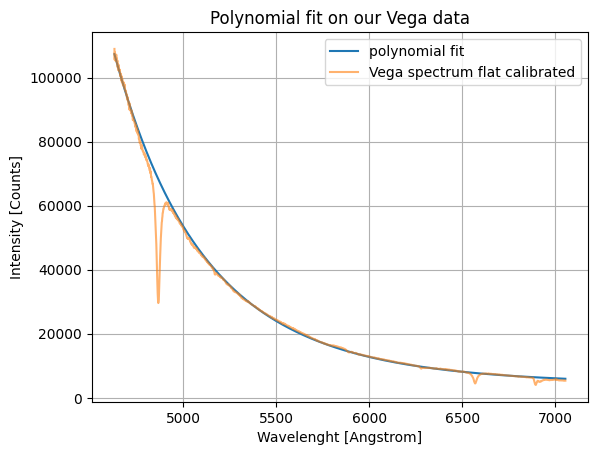

In [116]:
from scipy.optimize import curve_fit
def f(x,n,b,p):
    '''
    :purpose: Returns the value of the function f(x)=b+n/(x**p) function where b,n and p are constants
    :param x: Range of x values
    :param n: Constant
    :param b: Constant
    :param p: Constant
    :return: Value of the Gaussian function
    '''
    return b+n/(x**p)

line1 = np.polyfit((300,500),(interpolated_vega_calibration_values[300],interpolated_vega_calibration_values[500]),deg=1)
m1 = np.polyval(line1,range(300,500))

line2 = np.polyfit((1700,1900),(interpolated_vega_calibration_values[1700],interpolated_vega_calibration_values[1900]),deg=1)
m2 = np.polyval(line2,range(1700,1900))

line1_ourdata = np.polyfit((300,500),(Vega_flat_calibrated[300],Vega_flat_calibrated[500]),deg=1)
m1_ourdata = np.polyval(line1_ourdata,range(300,500))

line2_ourdata = np.polyfit((1700,1900),(Vega_flat_calibrated[1700],Vega_flat_calibrated[1900]),deg=1)
m2_ourdata = np.polyval(line2_ourdata,range(1700,1900))

no_peak_part1 = list(interpolated_vega_calibration_values[0:300])
no_peak_part2 = list(m1)
no_peak_part3 = list(interpolated_vega_calibration_values[500:1700])
no_peak_part4 = list(m2)
no_peak_part5 = list(interpolated_vega_calibration_values[1900:])

no_peak = no_peak_part1 + no_peak_part2 + no_peak_part3 + no_peak_part4 + no_peak_part5
no_peak = np.array(no_peak)

no_peak_ourdata_part1 = list(Vega_flat_calibrated[0:300])
no_peak_ourdata_part2 = list(m1_ourdata)
no_peak_ourdata_part3 = list(Vega_flat_calibrated[500:1700])
no_peak_ourdata_part4 = list(m2_ourdata)
no_peak_ourdata_part5 = list(Vega_flat_calibrated[1900:])

no_peak_ourdata = no_peak_ourdata_part1 + no_peak_ourdata_part2 + no_peak_ourdata_part3 + no_peak_ourdata_part4 + no_peak_ourdata_part5
no_peak_ourdata = np.array(no_peak_ourdata)

beta, pcov = curve_fit(f,wavelength_calibrated,no_peak, p0=(1*10**11,-1.5,1.27),bounds=((1*10**10.,-4.,0.),(1*10**12.,0.,10.)))
vega_calibration_fit = f(wavelength_calibrated, *beta)

beta_ourdata, pcov_ourdata = curve_fit(f,wavelength_calibrated,no_peak_ourdata, p0=( 1*10**39.7,10**3.7,9.5),bounds=((1*10**17.,10**2.,0.),(1*10**78.,10**5.,20.)))
Ourdata_fit = f(wavelength_calibrated, *beta_ourdata)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,vega_calibration_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, interpolated_vega_calibration_values, alpha = 0.6, label = 'Calibration data')
frame.set_title(f"Polynomial fit on the calibration data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Flux []')
fig.savefig('Calibrationd data fit.png', dpi = 300)
show(fig)
close(fig)


fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated,Ourdata_fit, label = 'polynomial fit')
frame.plot(wavelength_calibrated, Vega_flat_calibrated, alpha = 0.6, label = 'Vega spectrum flat calibrated')
frame.set_title(f"Polynomial fit on our Vega data")
frame.grid()
frame.legend()
frame.set_xlabel('Wavelenght [Angstrom]')
frame.set_ylabel('Intensity [Counts]')
fig.savefig('Our data fit.png', dpi = 300)
show(fig)
close(fig)

In [117]:
# Now we can calculate the response curve and calibrate our data
response = Ourdata_fit/vega_calibration_fit

# Let's apply this response curve to our data sets
Vega_response_corrected = Vega_flat_calibrated/response
Arcturus_response_corrected = Arcturus_flat_calibrated/response
Regulus_response_corrected = Regulus_flat_calibrated/response
Moon_response_corrected = Moon_flat_calibrated/response

In [118]:
def deriv(data: list, iterations: int = 1):
    """
    :param data: list containing curve to take the derivative from 
    :param iterations: the amount of times the derivative will be taken
    :return: returns the curve after taking iteration'th derivative  
    """
    if not isinstance(iterations, int):
        raise ValueError('iterations should be integer value')

    out = []
    out.append((data[1] - data[0]))
    for i in range(1, len(data) - 1):
        area_slope = ((data[i + 1] - data[i]) + (data[i] - data[i - 1])) / 2
        out.append(area_slope)
    out.append((data[-1] - data[-2]))
    iterations -= 1
    if iterations > 0:
        out = deriv(out, iterations)
    return np.array(out)


def get_peak_locations(data, edge_padding=1):
    """
    :param data: Curve to take the peak locations from 
    :param edge_padding: How many datapoints on the edges of the curve above the threshold should be ignored
    :return: returns tuple of (x, y) where x is the peak location and y is the height (y value) of the curve
    """
    array = data.copy()
    sectors = get_peak_sectors(array)
    peaks = []
    for left, right in sectors:
        min, max = None, None
        argmax = array[left:right].argmax() + left
        argmin = array[left:right].argmin() + left
        if not (argmin <= left + edge_padding or argmin >= right - edge_padding):
            valmin = array[left:right].min()
            min = (argmin, valmin)
            peaks.append(min)
        if not (argmax <= left + edge_padding or argmax >= right - edge_padding):
            valmax = array[left:right].max()
            max = (argmax, valmax)
            peaks.append(max)
        del argmax, argmin, min, max
    return peaks


def get_peak_sectors(array):
    """
    :param array: Curve to be cut up into pieces containing peaks. Separate peak regions by sections of numpy's NaN value
    :return: list of indexes where the numeric values begin and end
    """
    was_nan = True
    start = 0
    sectors = []
    for i, element in enumerate(array):
        is_nan = np.isnan(element)
        if not is_nan and was_nan:
            was_nan = False
            start = i
        elif is_nan and not was_nan:
            was_nan = True
            sectors.append([start, i])
            del start
    if not was_nan:
        sectors.append([start, len(array)])
    return sectors


def exclude(data, value, baseline=0, invert=False):
    """
    :param data: Curve from which to exclude sections 
    :param value: Value surrounding the baseline where the data is to be included/excluded depending on the invert kwarg (exclusion done by replacing the excluded point by NaN)
    :param baseline: Value around which to do the exclusion process
    :param invert: whether you want the section inside the cut-off line or outside the cut of line to be replaced with NaN's
    :return: returns the curve with the excluded sections replaced with NaN
    """
    dat = data.copy()
    value = np.abs(value)
    if not invert:
        excluded_array = np.where(np.abs(dat) < (baseline + value), np.nan, dat)
    else:
        excluded_array = np.where(np.abs(dat) > (baseline + value), np.nan, dat)
    return excluded_array

In [119]:
def process_peaks(raw_data, smoothed=True, deriv_count=2, thres_percent=1.5, power=3, normalise=True, name=''):
    """
    Complete process of getting the peak locations
    :param raw_data: Data to be processed for peaks (1d curve in np.array form)
    :param smoothed: Whether the processing should include smoothing or not (set False if your input is already smoothed)
    :param deriv_count: How many times the derivative should be taken, defaults to 2
    :param thres_percent: The percentile to be discarded (defaults to 1.5)
    :param power: The factor the peaks are to be taken to the power off for separating noise from data
    :param normalise: Whether the data should be normalized (divided by the highest value in the curve)
    :param name: Name of the object to be displayed in graphs
    :return: returns the peaks of the submitted curve
    """
    if smoothed:
        data = alsbaseline(raw_data, lam=100, remove=False, niter=2)
    else:
        data = raw_data

    if deriv_count > 0:
        derivative = deriv(data, deriv_count)
        derivative_adjusted = derivative ** power
    else:
        derivative_adjusted = data
        
    if normalise:
        if np.abs(derivative_adjusted.max()) > np.abs(derivative_adjusted.min()):
            derivative_adjusted /= derivative_adjusted.max()
        else:
            derivative_adjusted /= derivative_adjusted.min()
    else:
        if np.abs(derivative_adjusted.max()) < np.abs(derivative_adjusted.min()):
            derivative_adjusted *= -1

    threshold = np.percentile(derivative_adjusted, thres_percent)
    excluded_data = exclude(derivative_adjusted, threshold)
    peaks = get_peak_locations(excluded_data)
    sorted_peaks = peaks.copy()
    sorted_peaks.sort(key=lambda x: x[1], reverse=True)

    norm_curv = data / data.max()

    fig, ax = subplots()
    fig.suptitle(f'Peakfinding visualisation {name}')
    ax.set_xlabel('datapoint index')
    ax.set_ylabel('normalised "acceleration"')
    ax.plot(norm_curv, alpha=0.7, linestyle='--', color='navy', label=f'{name} (smooth)')
    ax.scatter(*zip(*peaks), c='r', s=5, label='peaks')
    ax.plot(derivative_adjusted, alpha=0.6, label='cubed derivative')
    ax.axhline(y=threshold, color='y', label='threshold')
    ax.axhline(y=-threshold, color='y')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.6)
    show()
    close(fig)
    return peaks

In [120]:
def spectra_picker(index):
    """
    :param index: ranging from 0 to 3 representing the object which data should be returned  
    :return: The raw data of the selected object
    """
    if index == 0:
        raw = Vega_response_corrected
    elif index == 1:
        raw = Arcturus_response_corrected
    elif index == 2:
        raw = Regulus_response_corrected
    elif index == 3:
        raw = Moon_response_corrected
    else:
        raise IndexError
    return raw


def peakfinding(name, data, smooth_data, output_type:str="xy_positive"):
    """
    :param name: Name of the object to be used for plotting and subfunctions
    :param data: Curve to be processed
    :param smooth_data: Curve but smoothed
    :param output_type: how the data should be output, options are: "xy_all", "xy_positive", "None"
    :return: None
    """
    fig, ax = subplots()
    ax.set_title(f'{name} spectra raw vs smoothed')
    ax.plot(data, label=f'{name} data raw')
    ax.plot(smooth_data, label=f'{name} data smoothed')
    ax.set_xlabel('pixel index')
    ax.set_ylabel('Flux')
    ax.legend()
    ax.grid()
    show()
    close(fig)

    threshold = {'Arcturus': 10, "Vega": 4, "Regulus": 2, "Moon": 8}
    # arcturus: thresh_percent = 10 (for most visible peaks)
    # vega: thresh_percent = 4 (for 3 main peaks)
    # regulus: thresh_percent = 2
    # moon: thresh_percent = 2

    rough_peaks = process_peaks(smooth_data, thres_percent=threshold[name], smoothed=False, name=name)
    positive_peaks = [peak for peak in rough_peaks if peak[1] > 0]

    fig, ax = subplots()
    ax.set_title(f'{name} data with peaks')
    ax.plot(data, c='navy', alpha=0.6, label=f'{name} raw data')
    for x, _ in positive_peaks:
        y = data[x]
        ax.scatter(x, y, s=20, c='r')
    ax.scatter(x, y, s=20, c='r', label='Peaks')
    ax.legend()
    ax.grid(alpha=0.6)
    ax.set_xlabel('datapoint index')
    ax.set_ylabel('intensity [counts]')
    show()
    close(fig)
    if output_type == "xy_all":
        return rough_peaks
    elif output_type == "xy_positive":
        return positive_peaks
    elif output_type == "None":
        return None

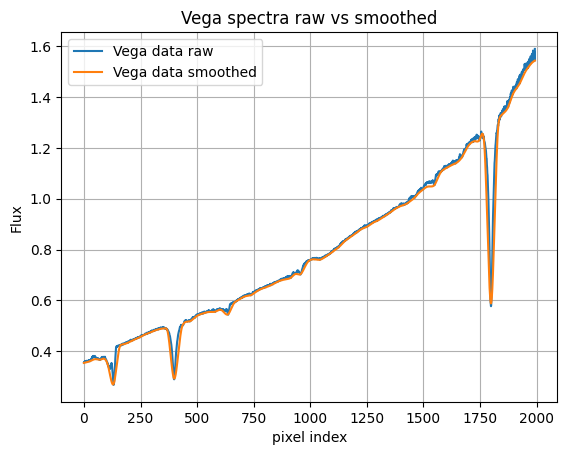

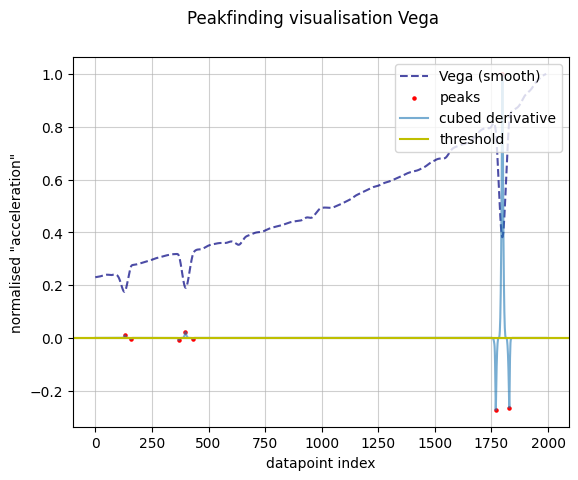

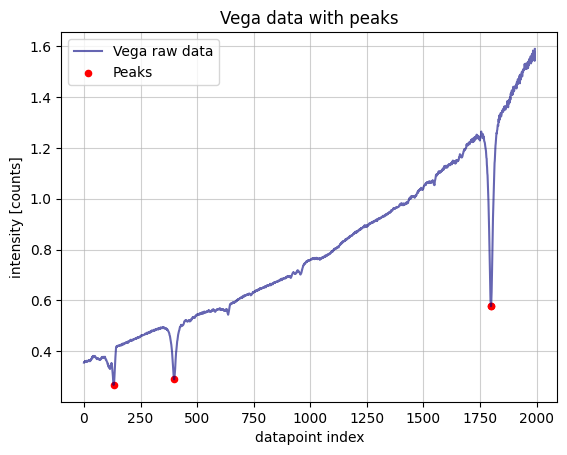

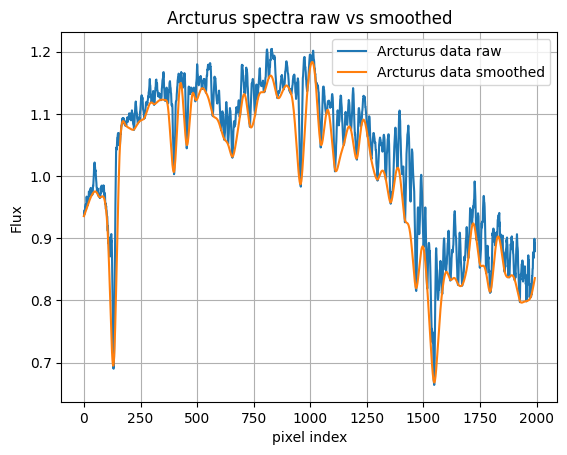

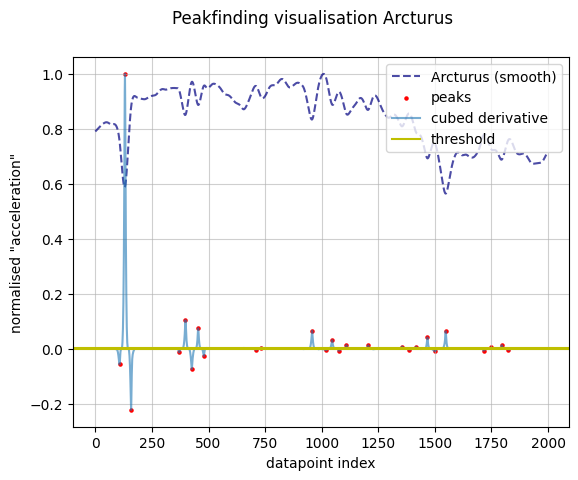

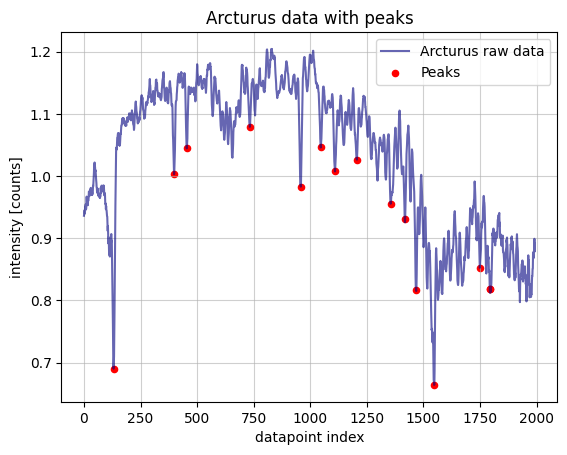

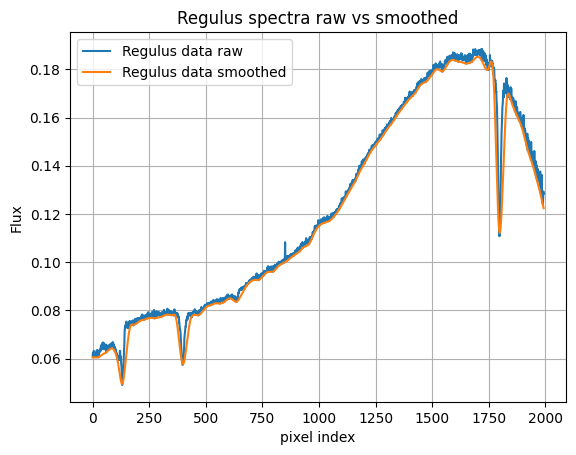

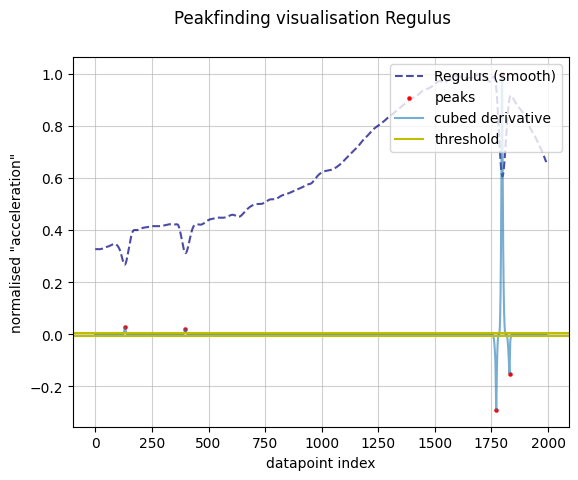

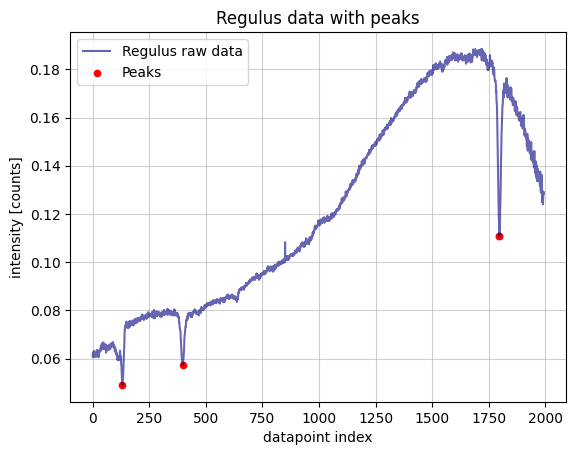

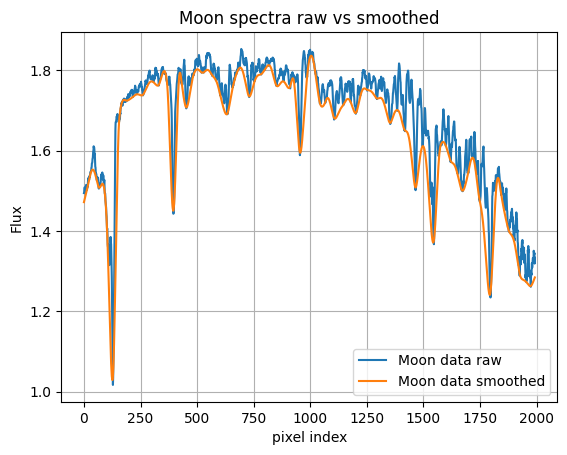

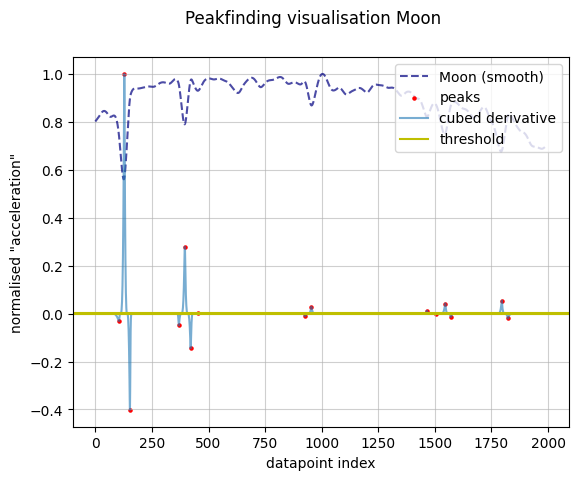

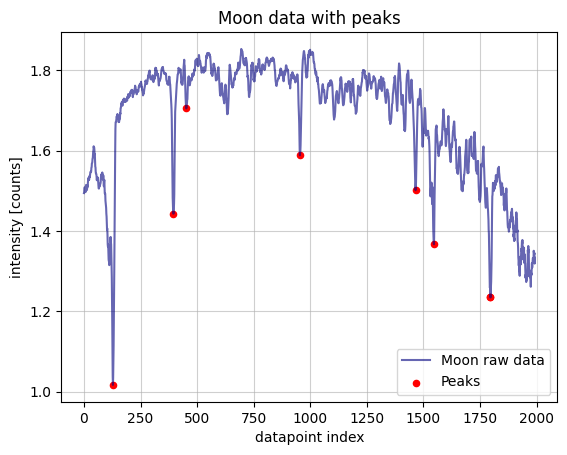

In [121]:
def run_peakfinding():
    """Runs the peakfinding algorithm"""
    objects = ['Vega', 'Arcturus', 'Regulus', 'Moon']
    peaks_dict = {}
    for i in range(len(objects)):
        raw = spectra_picker(i)
        smooth = alsbaseline(raw, lam=50, niter=5, remove=False)
        peaks = peakfinding(objects[i], raw, smooth)
        peaks_dict[objects[i]] = peaks
    return peaks_dict

peaks = run_peakfinding()

In [122]:
def pixels_to_wavelength(Array, xy=True, offset=True):
    '''
    :purpose: Function that converts an array of pixels to an array of wavelengths
    :param Array: Array of either, just x or an array with x and y coördinate peaks
    :return 1: Array of pixels flipped
    :return 2: Array of wavelengths
    '''
    if xy == True:
        peaks_pixel = []
        for x,_ in Array:
            peaks_pixel.append(int(x))
        return np.sort(peaks_pixel)[::-1], np.sort(np.polyval(y,peaks_pixel))
    else:
        if offset == True:
            return np.polyval(y,Array)
        else:
            return Array*y[1]

Arcturus_peaks_pixel, Arcturus_peaks = pixels_to_wavelength(peaks['Arcturus'])
Vega_peaks_pixel, Vega_peaks = pixels_to_wavelength(peaks['Vega'])
Regulus_peaks_pixel, Regulus_peaks = pixels_to_wavelength(peaks['Regulus'])
Moon_peaks_pixel, Moon_peaks = pixels_to_wavelength(peaks['Moon'])

print(f"Arcturus: ", Arcturus_peaks, Arcturus_peaks_pixel)
print(f"Vega: ", Vega_peaks, Vega_peaks_pixel)
print(f"Regulus: ", Regulus_peaks, Regulus_peaks_pixel)
print(f"Moon: ", Moon_peaks, Moon_peaks_pixel)

Arcturus:  [4867.88734533 4925.07811011 5169.65989141 5268.2226988  5329.06393793
 5404.50707444 5585.81396705 5703.84597096 5780.50593226 5887.58651312
 6161.3720892  6500.86620354 6569.00839136 6893.90060831] [1796 1749 1548 1467 1417 1355 1206 1109 1046  958  733  454  398  131]
Vega:  [4865.45369577 6569.00839136 6893.90060831] [1798  398  131]
Regulus:  [4866.67052055 6569.00839136 6893.90060831] [1797  398  131]
Moon:  [4867.88734533 5172.09354097 5270.65634836 5892.45381225 6503.2998531
 6572.65886571 6897.55108266] [1796 1546 1465  954  452  395  128]


In [123]:
# Identify the peaks and remove ones we aren't 100% sure of what they are
n_vega = ['Hβ - 4870','Hα - 6567','O2 - 6892']
# No need for cropping
n_Arcturus = ['Hβ - 4870','Mg I - 5178', 'Na I - 5894', 'Hα - 6567','O2 - 6892']
Arcturus_peaks_pixel_cropped = Arcturus_peaks_pixel[np.array([0,2,-5,-2,-1])]
Arcturus_peaks_cropped = Arcturus_peaks[np.array([0,2,-5,-2,-1])]
n_Regulus = ['Hβ - 4870', 'Hα - 6573', 'O2 - 6897']
# No need for cropping
n_Moon = ['Hβ - 4864', 'Mg I - 5169', 'Na I - 5890', 'Hα - 6569', 'O2 - 6896']
Moon_peaks_pixel_cropped = Moon_peaks_pixel[np.array([0,1,3,-2,-1])]
Moon_peaks_cropped = Moon_peaks[np.array([0,1,3,-2,-1])]
# [np.array([0,1,5,-2,-1])]

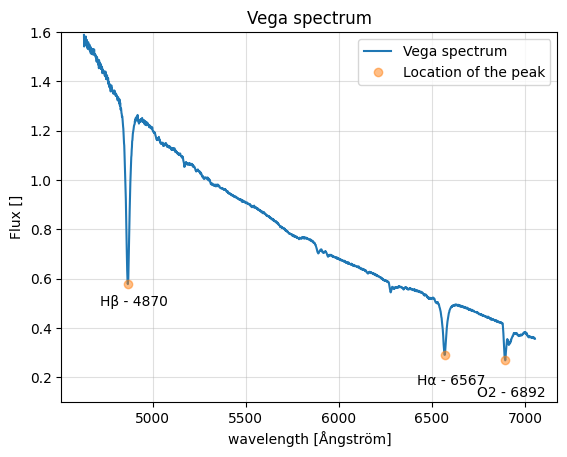

In [124]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Vega_response_corrected, label = 'Vega spectrum')
frame.plot(Vega_peaks,Vega_response_corrected[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Vega_response_corrected[Vega_peaks_pixel][i]), (Vega_peaks[i]-150-i, Vega_response_corrected[Vega_peaks_pixel][i]-0.09-i*0.03))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.1,1.6])
# fig.savefig('Vega response calibrated.png', dpi=300)
show(fig)
close(fig)

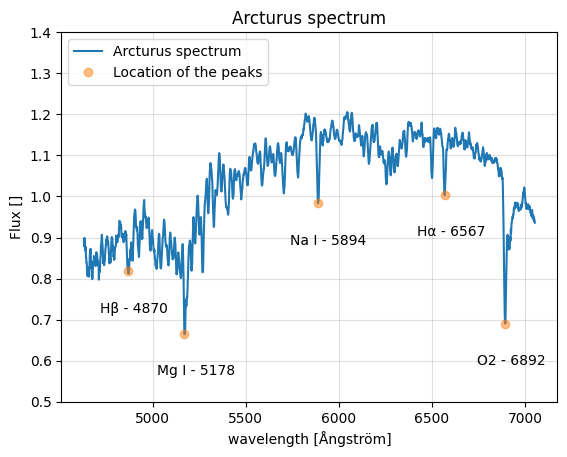

In [125]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Arcturus_response_corrected, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks_cropped,Arcturus_response_corrected[Arcturus_peaks_pixel_cropped], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus):
    frame.annotate(txt, (Arcturus_peaks_cropped[i], Arcturus_response_corrected[Arcturus_peaks_pixel_cropped][i]), (Arcturus_peaks_cropped[i]-150, Arcturus_response_corrected[Arcturus_peaks_pixel_cropped][i]-0.1))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'upper left')
frame.grid(alpha = 0.4)
frame.set_ylim(0.5,1.4)
# fig.savefig('Arcturus response calibrated.png', dpi=300)
show(fig)
close(fig)

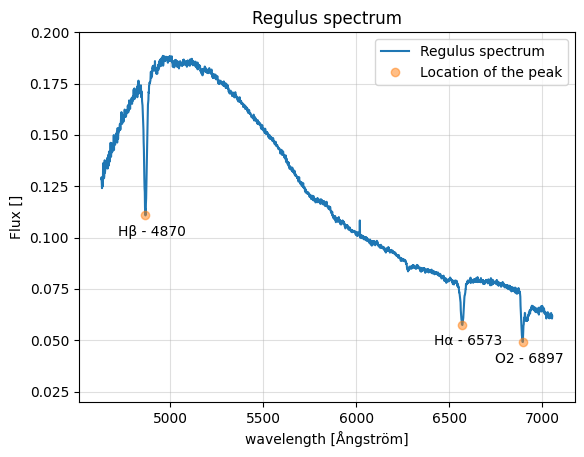

In [126]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Regulus_response_corrected, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Regulus_response_corrected[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Regulus_response_corrected[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Regulus_response_corrected[Regulus_peaks_pixel][i]-0.01))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.02,0.2])
# fig.savefig('Regulus response calibrated.png', dpi=300)
show(fig)
close(fig)

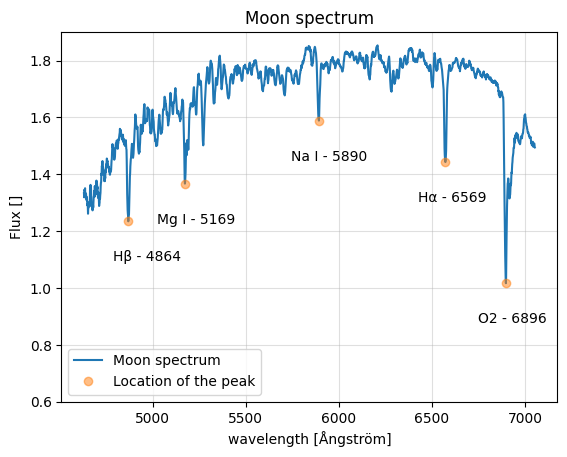

In [127]:
fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Moon_response_corrected, label = 'Moon spectrum')
frame.plot(Moon_peaks_cropped,Moon_response_corrected[Moon_peaks_pixel_cropped], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    if i == 0:
        frame.annotate(txt, (Moon_peaks_cropped[i], Moon_response_corrected[Moon_peaks_pixel_cropped][i]), (Moon_peaks_cropped[i]-80, Moon_response_corrected[Moon_peaks_pixel_cropped][i]-0.14))
    else:
        frame.annotate(txt, (Moon_peaks_cropped[i], Moon_response_corrected[Moon_peaks_pixel_cropped][i]), (Moon_peaks_cropped[i]-150, Moon_response_corrected[Moon_peaks_pixel_cropped][i]-0.14))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Flux []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim(0.6,1.9)
# fig.savefig('Moon response calibrated.png', dpi=300)
show(fig)
close(fig)

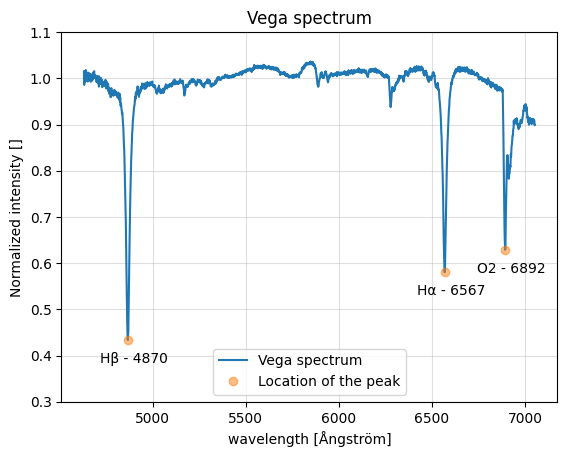

In [128]:
Flatlined_vega = Vega_response_corrected/vega_calibration_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatlined_vega, label = 'Vega spectrum')
frame.plot(Vega_peaks,Flatlined_vega[Vega_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_vega):
    frame.annotate(txt, (Vega_peaks[i], Flatlined_vega[Vega_peaks_pixel][i]), (Vega_peaks[i]-150, Flatlined_vega[Vega_peaks_pixel][i]-0.05))
frame.set_title(f"Vega spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.3,1.1])
# fig.savefig('Vega flatline.png', dpi=300)
show(fig)
close(fig)

[7053.30465483 7052.08783004 7050.87100526 ... 4631.82333751 4630.60651273
 4629.38968795]


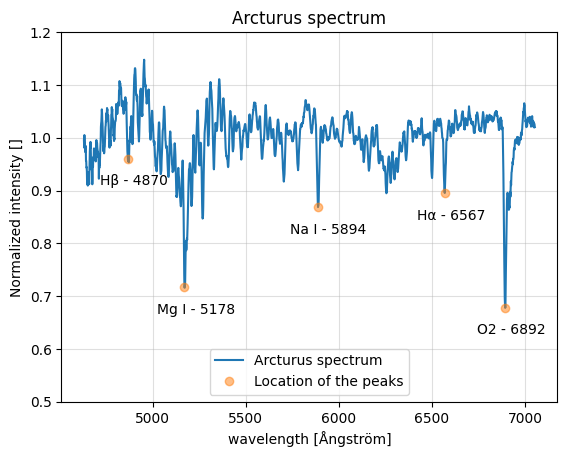

In [188]:
Arcturus_fit_function = np.polyfit(wavelength_calibrated, Arcturus_response_corrected, deg=5)
Arcturus_fit = np.polyval(Arcturus_fit_function, wavelength_calibrated)

Flatline_Arcturus = Arcturus_response_corrected/Arcturus_fit

print(wavelength_calibrated)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(Arcturus_peaks_cropped,Flatline_Arcturus[Arcturus_peaks_pixel_cropped], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peaks')
for i, txt in enumerate(n_Arcturus):
    frame.annotate(txt, (Arcturus_peaks_cropped[i], Flatline_Arcturus[Arcturus_peaks_pixel_cropped][i]), (Arcturus_peaks_cropped[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel_cropped][i]-0.05))
frame.set_title(f"Arcturus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend(loc = 'lower center')
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.2])
# fig.savefig('Arcturus flatline.png', dpi=300)
show(fig)
close(fig)

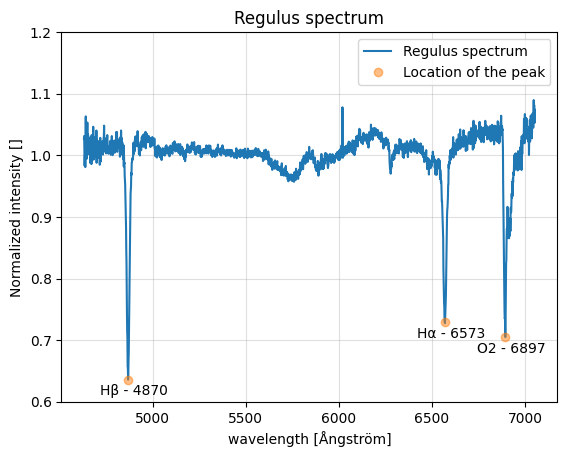

In [130]:
Regulus_fit_function = np.polyfit(wavelength_calibrated, Regulus_response_corrected, deg=5)
Regulus_fit = np.polyval(Regulus_fit_function, wavelength_calibrated)

Flatline_Regulus = Regulus_response_corrected / Regulus_fit

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label = 'Regulus spectrum')
frame.plot(Regulus_peaks,Flatline_Regulus[Regulus_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]), (Regulus_peaks[i]-150, Flatline_Regulus[Regulus_peaks_pixel][i]-0.025))
frame.set_title(f"Regulus spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
# fig.savefig('Regulus flatline.png', dpi=300)
frame.set_ylim([0.6,1.2])
show(fig)
close(fig)

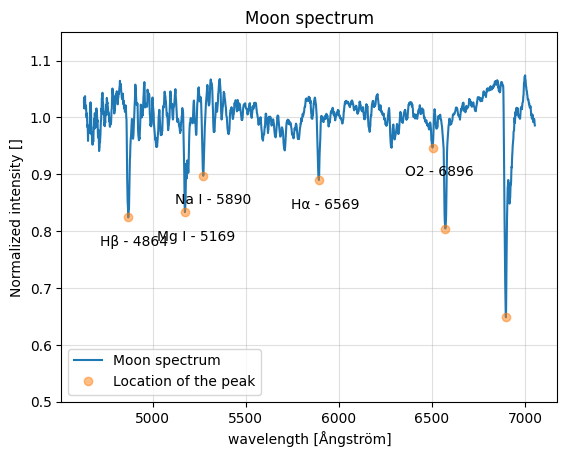

In [131]:
Moon_fit_function = np.polyfit(wavelength_calibrated, Moon_response_corrected, deg=8)
Moon_fit = np.abs(np.polyval(Moon_fit_function, wavelength_calibrated))

Flatline_Moon = (Moon_response_corrected / Moon_fit)

fig = figure()
frame = fig.add_subplot(1,1,1)
frame.plot(wavelength_calibrated, Flatline_Moon, label = 'Moon spectrum')
frame.plot(Moon_peaks,Flatline_Moon[Moon_peaks_pixel], marker = 'o', alpha = 0.5, linewidth = 0, label = 'Location of the peak')
for i, txt in enumerate(n_Moon):
    frame.annotate(txt, (Moon_peaks[i], Flatline_Moon[Moon_peaks_pixel][i]), (Moon_peaks[i]-150, Flatline_Moon[Moon_peaks_pixel][i]-0.05))
frame.set_title(f"Moon spectrum")
frame.set_ylabel('Normalized intensity []')
frame.set_xlabel('wavelength [Ångström]')
frame.legend()
frame.grid(alpha = 0.4)
frame.set_ylim([0.5,1.15])
# fig.savefig('Moon flatline.png', dpi=300)
show(fig)
close(fig)

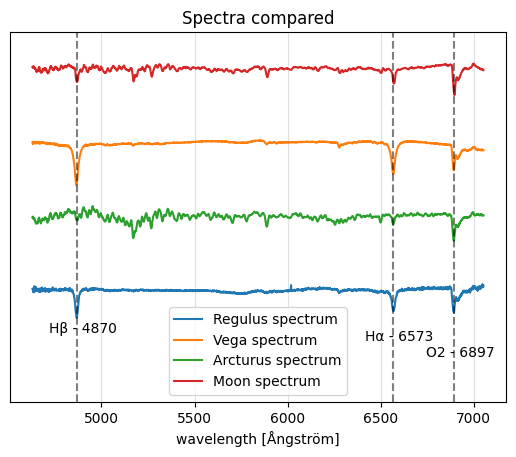

In [132]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Regulus, label='Regulus spectrum')
frame.plot(wavelength_calibrated, Flatlined_vega+2, label = 'Vega spectrum')
frame.plot(wavelength_calibrated, Flatline_Arcturus+1, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+3, label = 'Moon spectrum')
for i in Regulus_peaks:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
for i, txt in enumerate(n_Regulus):
    frame.annotate(txt, (Regulus_peaks[i], Flatline_Regulus[Moon_peaks_pixel][i]),
                   (Regulus_peaks[i] - 150, Flatline_Regulus[Regulus_peaks_pixel][i] - i*0.2-0.2))
frame.set_title(f"Spectra compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,4.5])
# fig.savefig('Spectra compared.png', dpi=300)
show(fig)
close(fig)

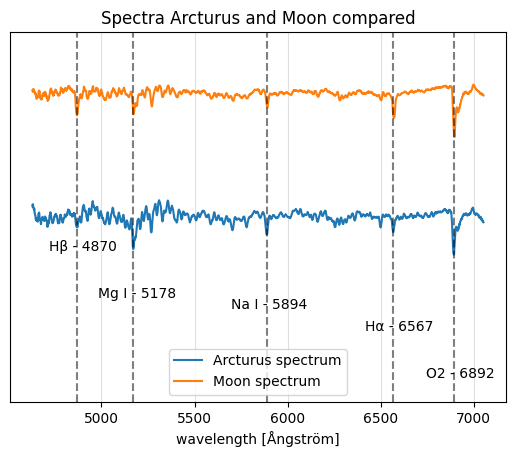

In [201]:
fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(wavelength_calibrated, Flatline_Arcturus, label = 'Arcturus spectrum')
frame.plot(wavelength_calibrated, Flatline_Moon+1, label = 'Moon spectrum')
for i in Arcturus_peaks_cropped:
    frame.axvline(i, color='k', linestyle='--', alpha=0.5)
for i, txt in enumerate(n_Arcturus):
    if i == 0 or i == 3 or i == 4:
        frame.annotate(txt, (Arcturus_peaks_cropped[i], Flatline_Arcturus[Moon_peaks_pixel_cropped][i]),(Arcturus_peaks_cropped[i]-150, Flatline_Arcturus[Arcturus_peaks_pixel_cropped][i] - i*0.2-0.2))
    else:
        frame.annotate(txt, (Arcturus_peaks_cropped[i], Flatline_Arcturus[Moon_peaks_pixel_cropped][i]),(Arcturus_peaks_cropped[i]-190, Flatline_Arcturus[Arcturus_peaks_pixel_cropped][i] - i*0.2-0.2))
frame.set_title(f"Spectra Arcturus and Moon compared")
frame.set_xlabel('wavelength [Ångström]')
frame.set_yticks([])
frame.legend(loc = 'lower center')
frame.grid(alpha=0.4)
frame.set_ylim([-0.5,2.5])
fig.savefig('Spectra compared Arctrurus and Moon.png', dpi=300)
show(fig)
close(fig)

H-alpha peak width: -29.08357284499104 Angstroms, error: -1.0227832531638157
H-beta peak width: -24.6991524090037 Angstroms, error: -1.517977801245028
O2 band width: -41.89018242763479 Angstroms, error: -3.0468823885906047
H-beta peak position: 4864.12723946716 Angstroms
H-alpha peak position: 6567.242248641168 Angstroms
O2 band peak position: 6903.56 Angstroms


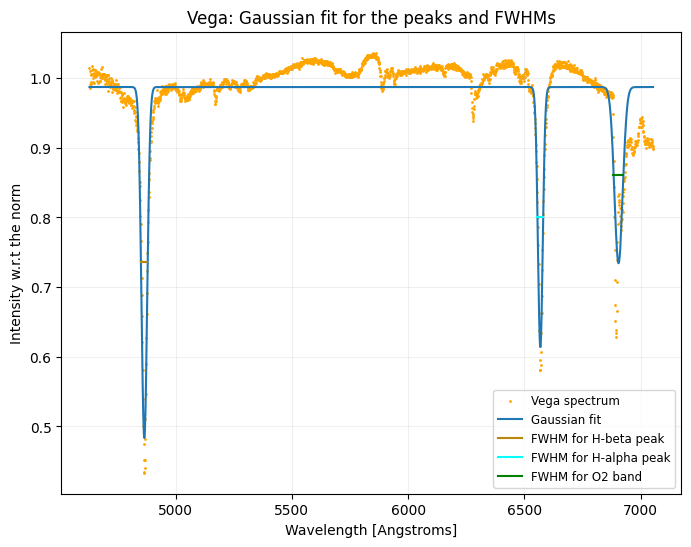

In [199]:
# Fitting Gaussians to the Vega peaks
def f_gaussian(x, amp, mu, sigma, zero):
    """returns the value of a Gaussian function with amplitude amp centered at position mu with width sigma and 
    offset with respect to the x-axis off zero"""
    return amp * np.exp(-(x - mu) * (x - mu) / (2.0 * sigma * sigma)) + zero

def f_exp(x, a,b,z):
    """returns an exponential function of the form a*exp(b*x)"""
    return a*np.exp(b*x)+z

def fit_gaussian(dat, p0, x_range):
    """Fits a Gaussian to the data and returns the parameters"""
    beta, pcov = curve_fit(f_gaussian, x_range, dat, p0=p0)
    a,m,s,z = beta
    return a,m,s,z,pcov

def fwhm_calculator(sigma,pcov):
    """Calculates the equivalent width from a given sigma value and its error using the pcov matrix"""
    fwhm=2*sigma*np.sqrt(2*np.log(2))
    err=np.sqrt(np.diag(pcov))
    fwhm_err=2*err[2]*np.sqrt(2*np.log(2))
    return fwhm,fwhm_err

def fwhm_points_calculator(a,m,z,fwhm):
    fwhm_x = pixels_to_wavelength(np.array((m-fwhm/2,m+fwhm/2)),xy=False)
    fwhm_y = np.array((a/2+z,a/2+z))
    return fwhm_x,fwhm_y

x_range = np.arange(1, Flatlined_vega.size+1)

a1,m1,s1,z1,pcov1 = fit_gaussian(Flatlined_vega,(-0.5, 1800, 10, 1),x_range)
a2,m2,s2,z2,pcov2 = fit_gaussian(Flatlined_vega,(-0.2, 400, 20, 1.02),x_range)
a3,m3,s3,z3,pcov3 = fit_gaussian(Flatlined_vega[100:200],(-0.4, 150, 20, 1.05),np.arange(100,200))

f_composed = f_gaussian(x_range,a1,m1,s1,z1)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)


# defining points for plotting the FWHMs
fwhm1_x,fwhm1_y = fwhm_points_calculator(a1,m1,z1,fwhm1)
fwhm2_x,fwhm2_y = fwhm_points_calculator(a2,m2,z1,fwhm2)
fwhm3_x,fwhm3_y = fwhm_points_calculator(a3,m3,z1,fwhm3)

# Convert to Angstroms using an earlier defined function
fwhm1_angstrom = pixels_to_wavelength(fwhm1, xy=False, offset=False)
fwhm1_err_angstrom = pixels_to_wavelength(fwhm1_err, xy=False, offset=False)

fwhm2_angstrom = pixels_to_wavelength(fwhm2, xy=False, offset=False)
fwhm2_err_angstrom = pixels_to_wavelength(fwhm2_err, xy=False, offset=False)

fwhm3_angstrom = pixels_to_wavelength(fwhm3, xy=False, offset=False)
fwhm3_err_angstrom = pixels_to_wavelength(fwhm3_err, xy=False, offset=False)


m1_a = pixels_to_wavelength(m1, xy=False)
m2_a = pixels_to_wavelength(m2, xy=False)
m3_a = pixels_to_wavelength(m3, xy=False)

print(f"H-alpha peak width: {fwhm1_angstrom} Angstroms, error: {fwhm1_err_angstrom}")
print(f"H-beta peak width: {fwhm2_angstrom} Angstroms, error: {fwhm2_err_angstrom}")
print(f"O2 band width: {fwhm3_angstrom} Angstroms, error: {fwhm3_err_angstrom}")

print(f"H-beta peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")
print(f"O2 band peak position: {m3_a:.2f} Angstroms")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(wavelength_calibrated,Flatlined_vega,color="orange", label="Vega spectrum",s=1)
frame.plot(wavelength_calibrated,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x,fwhm1_y,color="darkgoldenrod", label="FWHM for H-beta peak")
frame.plot(fwhm2_x,fwhm2_y,color="cyan", label="FWHM for H-alpha peak")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for O2 band")
frame.set_title("Vega: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

O2 band peak width: 14.434797507151782 Angstroms, error: 1.021972043640081
H-alpha peak width: 13.375472922812857 Angstroms, error: 2.7015309272119743
Na I peakwidth: 11.521825696075862 Angstroms, error: 1.9528440141836347
Mg I peak width: 42.151243749920134 Angstroms, error: 2.9835164805964904
H-beta peak width: 12.680716870916719 Angstroms, error: 12.680716870916719

O2 band peak position: 6893.371874788719 Angstroms
H-alpha peak position: 6567.7501836112515 Angstroms
Na I peak position: 5887.48 Angstroms
Mg I peak position: 5172.48 Angstroms
H-beta peak position: 4867.49 Angstroms


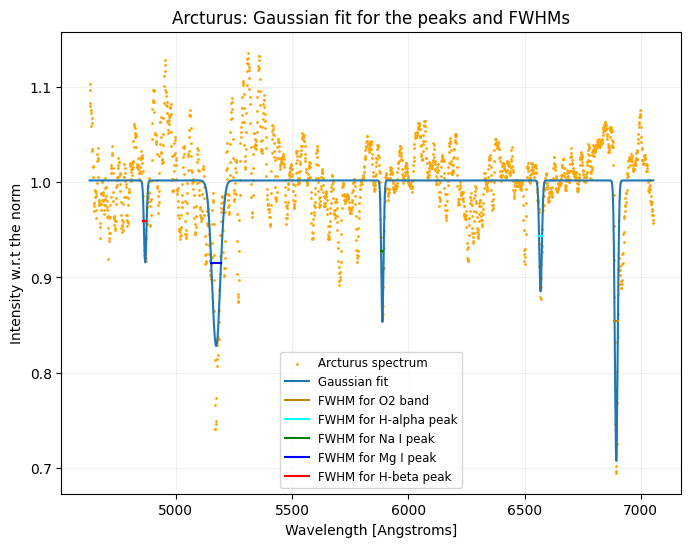

In [221]:
# Fitting to Arcturus data
# We use a higher degree polynomial
Arcturus_fit_function = np.polyfit(wavelength_calibrated, Arcturus_response_corrected, deg=8)
Arcturus_fit = np.polyval(Arcturus_fit_function, wavelength_calibrated)
Flatline_Arcturus = Arcturus_response_corrected/Arcturus_fit

a1,m1,s1,z1,pcov1 = fit_gaussian(Flatline_Arcturus,(-1,125,1,1),x_range)
a2,m2,s2,z2,pcov2 = fit_gaussian(Flatline_Arcturus,(-0.2,400,5,1),x_range)
a3,m3,s3,z3,pcov3 = fit_gaussian(Flatline_Arcturus,(-0.1,950,10,1),x_range)
a4,m4,s4,z4,pcov4 = fit_gaussian(Flatline_Arcturus,(-1,1550,10,1),x_range)
a5,m5,s5,z5,pcov5 = fit_gaussian(Flatline_Arcturus,(-1,1780,5,1),x_range)

f_composed = f_gaussian(x_range,a1,m1,s1,z1)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)+f_gaussian(x_range,a4,m4,s4,0)+f_gaussian(x_range,a5,m5,s5,0)

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)
fwhm4,fwhm4_err=fwhm_calculator(s4,pcov4)
fwhm5,fwhm5_err=fwhm_calculator(s5,pcov5)

# defining points for plotting the FWHMs
fwhm1_x,fwhm1_y = fwhm_points_calculator(a1,m1,z1,fwhm1)
fwhm2_x,fwhm2_y = fwhm_points_calculator(a2,m2,z1,fwhm2)
fwhm3_x,fwhm3_y = fwhm_points_calculator(a3,m3,z1,fwhm3)
fwhm4_x,fwhm4_y = fwhm_points_calculator(a4,m4,z1,fwhm4)
fwhm5_x,fwhm5_y = fwhm_points_calculator(a5,m5,z1,fwhm5)


# Convert to Angstroms using an earlier defined function
fwhm1_angstrom = pixels_to_wavelength(fwhm1, xy=False, offset=False)
fwhm1_err_angstrom = pixels_to_wavelength(fwhm1_err, xy=False, offset=False)

fwhm2_angstrom = pixels_to_wavelength(fwhm2, xy=False, offset=False)
fwhm2_err_angstrom = pixels_to_wavelength(fwhm2_err, xy=False, offset=False)

fwhm3_angstrom = pixels_to_wavelength(fwhm3, xy=False, offset=False)
fwhm3_err_angstrom = pixels_to_wavelength(fwhm3_err, xy=False, offset=False)

fwhm4_angstrom = pixels_to_wavelength(fwhm4, xy=False, offset=False)
fwhm4_err_angstrom = pixels_to_wavelength(fwhm4_err, xy=False, offset=False)

fwhm5_angstrom = pixels_to_wavelength(fwhm5, xy=False, offset=False)
fwhm5_err_angstrom = pixels_to_wavelength(fwhm5, xy=False, offset=False)

m1_a = pixels_to_wavelength(m1, xy=False)
m2_a = pixels_to_wavelength(m2, xy=False)
m3_a = pixels_to_wavelength(m3, xy=False)
m4_a = pixels_to_wavelength(m4, xy=False)
m5_a = pixels_to_wavelength(m5, xy=False)

print(f"O2 band peak width: {np.abs(fwhm1_angstrom)} Angstroms, error: {np.abs(fwhm1_err_angstrom)}")
print(f"H-alpha peak width: {np.abs(fwhm2_angstrom)} Angstroms, error: {np.abs(fwhm2_err_angstrom)}")
print(f"Na I peakwidth: {np.abs(fwhm3_angstrom)} Angstroms, error: {np.abs(fwhm3_err_angstrom)}")
print(f"Mg I peak width: {np.abs(fwhm4_angstrom)} Angstroms, error: {np.abs(fwhm4_err_angstrom)}")
print(f"H-beta peak width: {np.abs(fwhm5_angstrom)} Angstroms, error: {np.abs(fwhm5_err_angstrom)}")

print('')

print(f"O2 band peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")
print(f"Na I peak position: {m3_a:.2f} Angstroms")
print(f"Mg I peak position: {m4_a:.2f} Angstroms")
print(f"H-beta peak position: {m5_a:.2f} Angstroms")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(wavelength_calibrated,Flatline_Arcturus,color="orange", label="Arcturus spectrum",s=1)
frame.plot(wavelength_calibrated,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x,fwhm1_y,color="darkgoldenrod", label="FWHM for O2 band")
frame.plot(fwhm2_x,fwhm2_y,color="cyan", label="FWHM for H-alpha peak")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for Na I peak")
frame.plot(fwhm4_x,fwhm4_y,color="blue", label="FWHM for Mg I peak")
frame.plot(fwhm5_x,fwhm5_y,color="red", label="FWHM for H-beta peak")
frame.set_title("Arcturus: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

H-alpha peak width: -17.996293281113395 Angstroms, error: -0.8046889033745841
H-beta peak width: -22.55114247512111 Angstroms, error: -1.3023917188947218
O2 band width: -38.5637690773998 Angstroms, error: -2.848576858317621
H-beta peak position: 4866.72379587698 Angstroms
H-alpha peak position: 6569.545207390246 Angstroms
O2 band peak position: 6902.27 Angstroms


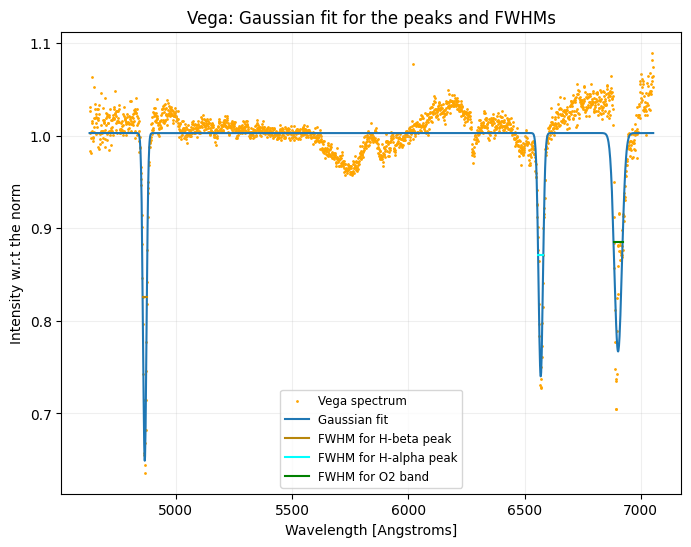

In [161]:
# Fitting to Regulus data
a1,m1,s1,z1,pcov1 = fit_gaussian(Flatline_Regulus,(-0.5, 1800, 10, 1),x_range)
a2,m2,s2,z2,pcov2 = fit_gaussian(Flatline_Regulus,(-0.2, 400, 20, 1.02),x_range)
a3,m3,s3,z3,pcov3 = fit_gaussian(Flatline_Regulus[100:200],(-0.4, 150, 20, 1.05),np.arange(100,200))

f_composed = f_gaussian(x_range,a1,m1,s1,z1)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)

# defining points for plotting the FWHMs
fwhm1_x = pixels_to_wavelength(np.array((m1-fwhm1/2,m1+fwhm1/2)),xy=False)
fwhm1_y = np.array((a1/2+z1,a1/2+z1))

fwhm2_x = pixels_to_wavelength(np.array((m2-fwhm2/2,m2+fwhm2/2)),xy=False)
fwhm2_y = np.array((a2/2+z1,a2/2+z1))

fwhm3_x = pixels_to_wavelength(np.array((m3-fwhm3/2,m3+fwhm3/2)),xy=False)
fwhm3_y = np.array((a3/2+z1,a3/2+z1))

# Convert to Angstroms using an earlier defined function
fwhm1_angstrom = pixels_to_wavelength(fwhm1, xy=False, offset=False)
fwhm1_err_angstrom = pixels_to_wavelength(fwhm1_err, xy=False, offset=False)

fwhm2_angstrom = pixels_to_wavelength(fwhm2, xy=False, offset=False)
fwhm2_err_angstrom = pixels_to_wavelength(fwhm2_err, xy=False, offset=False)

fwhm3_angstrom = pixels_to_wavelength(fwhm3, xy=False, offset=False)
fwhm3_err_angstrom = pixels_to_wavelength(fwhm3_err, xy=False, offset=False)

m1_a = pixels_to_wavelength(m1, xy=False)
m2_a = pixels_to_wavelength(m2, xy=False)
m3_a = pixels_to_wavelength(m3, xy=False)

print(f"H-alpha peak width: {fwhm1_angstrom} Angstroms, error: {fwhm1_err_angstrom}")
print(f"H-beta peak width: {fwhm2_angstrom} Angstroms, error: {fwhm2_err_angstrom}")
print(f"O2 band width: {fwhm3_angstrom} Angstroms, error: {fwhm3_err_angstrom}")

print(f"H-beta peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")
print(f"O2 band peak position: {m3_a:.2f} Angstroms")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(wavelength_calibrated,Flatline_Regulus,color="orange", label="Regulus spectrum",s=1)
frame.plot(wavelength_calibrated,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x,fwhm1_y,color="darkgoldenrod", label="FWHM for H-beta peak")
frame.plot(fwhm2_x,fwhm2_y,color="cyan", label="FWHM for H-alpha peak")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for O2 band")
frame.set_title("Regulus: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

O2 band peak width: 18.739928532303026 Angstroms, error: 0.9409469579974765
H-alpha peak width: 15.528712409114501 Angstroms, error: 1.4252146429508847
Na I peakwidth: 11.936650874796136 Angstroms, error: 2.3521389867974087
Mg I peak width: 23.350863816660556 Angstroms, error: 2.6956999807964674
H-beta peak width: 14.027911813840692 Angstroms, error: 14.027911813840692

O2 band peak position: 6898.007771617347 Angstroms
H-alpha peak position: 6571.10366472053 Angstroms
Na I peak position: 5890.24 Angstroms
Mg I peak position: 5176.87 Angstroms
H-beta peak position: 4867.87 Angstroms


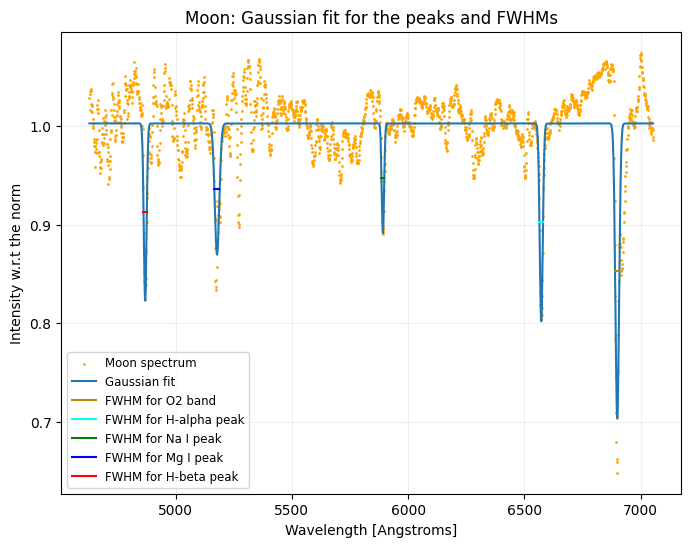

In [220]:
# Fitting to Moon data
a1,m1,s1,z1,pcov1 = fit_gaussian(Flatline_Moon,(-1,125,1,1),x_range)
a2,m2,s2,z2,pcov2 = fit_gaussian(Flatline_Moon,(-0.2,400,5,1),x_range)
a3,m3,s3,z3,pcov3 = fit_gaussian(Flatline_Moon,(-0.1,950,10,1),x_range)
a4,m4,s4,z4,pcov4 = fit_gaussian(Flatline_Moon,(-1,1550,10,1),x_range)
a5,m5,s5,z5,pcov5 = fit_gaussian(Flatline_Moon,(-1,1780,5,1),x_range)

f_composed = f_gaussian(x_range,a1,m1,s1,z1)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)+f_gaussian(x_range,a4,m4,s4,0)+f_gaussian(x_range,a5,m5,s5,0)

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)
fwhm4,fwhm4_err=fwhm_calculator(s4,pcov4)
fwhm5,fwhm5_err=fwhm_calculator(s5,pcov5)

# defining points for plotting the FWHMs
fwhm1_x,fwhm1_y = fwhm_points_calculator(a1,m1,z1,fwhm1)
fwhm2_x,fwhm2_y = fwhm_points_calculator(a2,m2,z1,fwhm2)
fwhm3_x,fwhm3_y = fwhm_points_calculator(a3,m3,z1,fwhm3)
fwhm4_x,fwhm4_y = fwhm_points_calculator(a4,m4,z1,fwhm4)
fwhm5_x,fwhm5_y = fwhm_points_calculator(a5,m5,z1,fwhm5)


# Convert to Angstroms using an earlier defined function
fwhm1_angstrom = pixels_to_wavelength(fwhm1, xy=False, offset=False)
fwhm1_err_angstrom = pixels_to_wavelength(fwhm1_err, xy=False, offset=False)

fwhm2_angstrom = pixels_to_wavelength(fwhm2, xy=False, offset=False)
fwhm2_err_angstrom = pixels_to_wavelength(fwhm2_err, xy=False, offset=False)

fwhm3_angstrom = pixels_to_wavelength(fwhm3, xy=False, offset=False)
fwhm3_err_angstrom = pixels_to_wavelength(fwhm3_err, xy=False, offset=False)

fwhm4_angstrom = pixels_to_wavelength(fwhm4, xy=False, offset=False)
fwhm4_err_angstrom = pixels_to_wavelength(fwhm4_err, xy=False, offset=False)

fwhm5_angstrom = pixels_to_wavelength(fwhm5, xy=False, offset=False)
fwhm5_err_angstrom = pixels_to_wavelength(fwhm5, xy=False, offset=False)

m1_a = pixels_to_wavelength(m1, xy=False)
m2_a = pixels_to_wavelength(m2, xy=False)
m3_a = pixels_to_wavelength(m3, xy=False)
m4_a = pixels_to_wavelength(m4, xy=False)
m5_a = pixels_to_wavelength(m5, xy=False)

print(f"O2 band peak width: {np.abs(fwhm1_angstrom)} Angstroms, error: {np.abs(fwhm1_err_angstrom)}")
print(f"H-alpha peak width: {np.abs(fwhm2_angstrom)} Angstroms, error: {np.abs(fwhm2_err_angstrom)}")
print(f"Na I peakwidth: {np.abs(fwhm3_angstrom)} Angstroms, error: {np.abs(fwhm3_err_angstrom)}")
print(f"Mg I peak width: {np.abs(fwhm4_angstrom)} Angstroms, error: {np.abs(fwhm4_err_angstrom)}")
print(f"H-beta peak width: {np.abs(fwhm5_angstrom)} Angstroms, error: {np.abs(fwhm5_err_angstrom)}")

print('')

print(f"O2 band peak position: {m1_a} Angstroms")
print(f"H-alpha peak position: {m2_a} Angstroms")
print(f"Na I peak position: {m3_a:.2f} Angstroms")
print(f"Mg I peak position: {m4_a:.2f} Angstroms")
print(f"H-beta peak position: {m5_a:.2f} Angstroms")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(wavelength_calibrated,Flatline_Moon,color="orange", label="Moon spectrum",s=1)
frame.plot(wavelength_calibrated,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x,fwhm1_y,color="darkgoldenrod", label="FWHM for O2 band")
frame.plot(fwhm2_x,fwhm2_y,color="cyan", label="FWHM for H-alpha peak")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for Na I peak")
frame.plot(fwhm4_x,fwhm4_y,color="blue", label="FWHM for Mg I peak")
frame.plot(fwhm5_x,fwhm5_y,color="red", label="FWHM for H-beta peak")
frame.set_title("Moon: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)

First Cd peak width: -9.71791673213062 Angstroms, error: -4.6286348789174365
Hg peak width: -11.24085497852239 Angstroms, error: -0.26380272216948
Second Cd width: -10.49170126758053 Angstroms, error: -1.5501848245128778
First Cd peak position: 6440.998451746862 Angstroms
Hg peak position: 5459.232964275023 Angstroms
Second Cd peak position: 5088.04 Angstroms


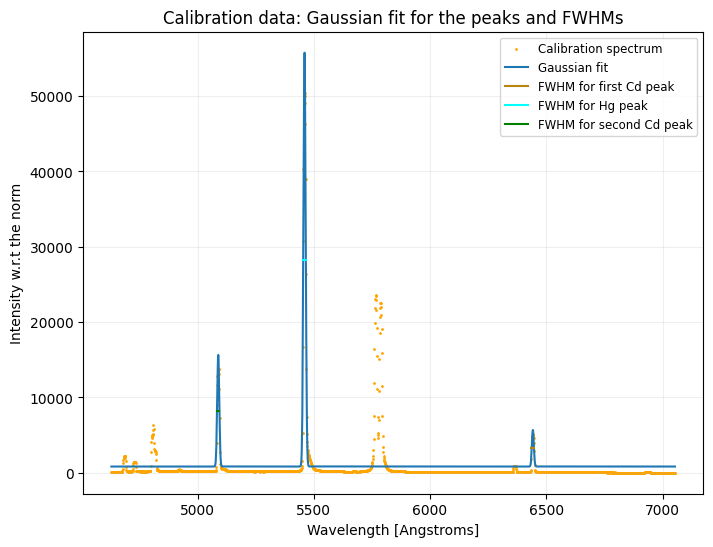

In [213]:
# Fitting to calibration data
a1,m1,s1,z1,pcov1 = fit_gaussian(cropped_calibration[location_of_maximum_calibration],(12000,500,1,0),x_range)
a2,m2,s2,z2,pcov2 = fit_gaussian(cropped_calibration[location_of_maximum_calibration],(50000,1300,5,0),x_range)
a3,m3,s3,z3,pcov3 = fit_gaussian(cropped_calibration[location_of_maximum_calibration],(8000,1625,10,0),x_range)

f_composed = f_gaussian(x_range,a1,m1,s1,z1)+f_gaussian(x_range,a2,m2,s2,0)+f_gaussian(x_range,a3,m3,s3,0)

fwhm1,fwhm1_err=fwhm_calculator(s1,pcov1)
fwhm2,fwhm2_err=fwhm_calculator(s2,pcov2)
fwhm3,fwhm3_err=fwhm_calculator(s3,pcov3)

# defining points for plotting the FWHMs
fwhm1_x,fwhm1_y = fwhm_points_calculator(a1,m1,z1,fwhm1)
fwhm2_x,fwhm2_y = fwhm_points_calculator(a2,m2,z1,fwhm2)
fwhm3_x,fwhm3_y = fwhm_points_calculator(a3,m3,z1,fwhm3)

# Convert to Angstroms using an earlier defined function
fwhm1_angstrom = pixels_to_wavelength(fwhm1, xy=False, offset=False)
fwhm1_err_angstrom = pixels_to_wavelength(fwhm1_err, xy=False, offset=False)

fwhm2_angstrom = pixels_to_wavelength(fwhm2, xy=False, offset=False)
fwhm2_err_angstrom = pixels_to_wavelength(fwhm2_err, xy=False, offset=False)

fwhm3_angstrom = pixels_to_wavelength(fwhm3, xy=False, offset=False)
fwhm3_err_angstrom = pixels_to_wavelength(fwhm3_err, xy=False, offset=False)

m1_a = pixels_to_wavelength(m1, xy=False)
m2_a = pixels_to_wavelength(m2, xy=False)
m3_a = pixels_to_wavelength(m3, xy=False)


print(f"First Cd peak width: {fwhm1_angstrom} Angstroms, error: {fwhm1_err_angstrom}")
print(f"Hg peak width: {fwhm2_angstrom} Angstroms, error: {fwhm2_err_angstrom}")
print(f"Second Cd width: {fwhm3_angstrom} Angstroms, error: {fwhm3_err_angstrom}")

print(f"First Cd peak position: {m1_a} Angstroms")
print(f"Hg peak position: {m2_a} Angstroms")
print(f"Second Cd peak position: {m3_a:.2f} Angstroms")

fig=figure(figsize=(8,6))
frame=fig.add_subplot(1,1,1)
frame.scatter(wavelength_calibrated,cropped_calibration[location_of_maximum_calibration],color="orange", label="Calibration spectrum",s=1)
frame.plot(wavelength_calibrated,f_composed, label="Gaussian fit")
frame.plot(fwhm1_x,fwhm1_y,color="darkgoldenrod", label="FWHM for first Cd peak")
frame.plot(fwhm2_x,fwhm2_y,color="cyan", label="FWHM for Hg peak")
frame.plot(fwhm3_x,fwhm3_y,color="green", label="FWHM for second Cd peak")
frame.set_title("Calibration data: Gaussian fit for the peaks and FWHMs")
frame.grid(alpha=0.2)
frame.set_ylabel("Intensity w.r.t the norm")
frame.set_xlabel("Wavelength [Angstroms]")
frame.legend(fontsize=8.5)
show()
close(fig)